In [1]:
import os
import json
import pandas as pd
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline

In [2]:
def load_df(train_dir = 'save_train_dir/'):
    df = []
    for dirname, dirnames, filenames in os.walk(train_dir):
        for f in filenames:
            path_file = '{}/{}'.format(dirname, f)
            with open(path_file) as json_file:
                H = json.load(json_file)
                df.append([ str(H['parent_selection']), str(H['survivor_selection']), 
                            H['k_tournament'], H['p_tournament'], float(H['generations']), 
                            H['population_size'], str(H['crossover_selection']), 
                            str(H['mutation_selection']), float(H['run-time']), 
                            float(H['solution'][1]), float(H['solution'][2])*1000000, H['solution'][0]])
    df = pd.DataFrame(df, columns = [ 'parent_selection', 'survivor_selection', 'k_tournament', 'p_tournament', 
                                      'generations', 'population_size', 'crossover_selection', 'mutation_selection', 
                                      'run-time', 'min_distance', 'fitness*1000000', 'solution'])
    return df

df = load_df()
df['mutation_selection'] = df['mutation_selection'].replace({'rsm': 1, 'cim': 2})

In [7]:
def parallel_plot(df,cols,rank_attr, title, output, cmap='Spectral',spread=None,curved=False,curvedextend=0.1):
    '''
    This cose was taken and modified from the following repository:
    https://github.com/jraine/parallel-coordinates-plot-dataframe
    ---------------------------------------------------------------
    Produce a parallel coordinates plot from pandas dataframe with line colour with respect to a column.
    Required Arguments:
        df: dataframe
        cols: columns to use for axes
        rank_attr: attribute to use for ranking
        title: title
        output: output path to save the figure
    Options:
        cmap: Colour palette to use for ranking of lines
        spread: Spread to use to separate lines at categorical values
        curved: Spline interpolation along lines
        curvedextend: Fraction extension in y axis, adjust to contain curvature
    Returns:
        x coordinates for axes, y coordinates of all lines'''
    def width_func(v):
        if v > 1:
            return 3.5*v
        else:
            return 2*v
        
    colmap = matplotlib.cm.get_cmap(cmap)
    cols = cols + [rank_attr]
    plt.style.use('seaborn-whitegrid')
    fig, axes = plt.subplots(1, len(cols)-1, sharey=False, figsize=(3.1*len(cols)+3,8))
    valmat = np.ndarray(shape=(len(cols),len(df)))
    x = np.arange(0,len(cols),1)
    ax_info = {}
    for i,col in enumerate(cols):
        vals = df[col]
        if (vals.dtype == float) & (len(np.unique(vals)) > 20):
            minval = np.min(vals)
            maxval = np.max(vals)
            rangeval = maxval - minval
            vals = np.true_divide(vals - minval, maxval-minval)
            nticks = 5
            tick_labels = [round(minval + i*(rangeval/nticks),4) for i in range(nticks+1)]
            ticks = [0 + i*(1.0/nticks) for i in range(nticks+1)]
            valmat[i] = vals
            ax_info[col] = [tick_labels,ticks]
        else:
            vals = vals.astype('category')
            cats = vals.cat.categories
            c_vals = vals.cat.codes
            minval = 0
            maxval = len(cats)-1
            if maxval == 0:
                c_vals = 0.5
            else:
                c_vals = np.true_divide(c_vals - minval, maxval-minval)
            tick_labels = cats
            ticks = np.unique(c_vals)
            ax_info[col] = [tick_labels,ticks]
            if spread is not None:
                offset = np.arange(-1,1,2./(len(c_vals)))*2e-2
                np.random.shuffle(offset)
                c_vals = c_vals + offset
            valmat[i] = c_vals
            
    extendfrac = curvedextend if curved else 0.05  
    for i,ax in enumerate(axes):
        for idx in range(valmat.shape[-1]):
            if curved:
                x_new = np.linspace(0, len(x), len(x)*20)
                a_BSpline = make_interp_spline(x, valmat[:,idx],k=3,bc_type='clamped')
                y_new = a_BSpline(x_new)
                ax.plot(x_new,y_new,color=colmap(valmat[-1,idx]),alpha= (7542 / (1.8*df['min_distance'].values[idx])), linewidth = width_func(8000 / df['min_distance'].values[idx]))
            else:
                ax.plot(x,valmat[:,idx],color=colmap(valmat[-1,idx]),alpha= (7542 / (1.8*df['min_distance'].values[idx])), linewidth = width_func(8000 / df['min_distance'].values[idx]) )
        ax.set_ylim(0-extendfrac,1+extendfrac)
        ax.set_xlim(i,i+1)
    
    for dim, (ax,col) in enumerate(zip(axes,cols)):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax_info[col][1]))
        ax.set_yticklabels(ax_info[col][0])
        ax.set_xticklabels([cols[dim]])
        ax.grid(False)
    
    plt.subplots_adjust(wspace=0)
    norm = matplotlib.colors.Normalize(0, 1)#*axes[-1].get_ylim())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    cbar = plt.colorbar(sm,pad=0,ticks=ax_info[rank_attr][1],extend='both',extendrect=True,extendfrac=extendfrac)
    if curved:
        cbar.ax.set_ylim(0-curvedextend,1+curvedextend)
        
    cbar.ax.set_yticklabels(ax_info[rank_attr][0])
    cbar.ax.set_xlabel(rank_attr)
    plt.title(title)
    plt.savefig(output, bbox_inches='tight', dpi = 150)
    plt.show()
    return x,valmat

Total number of experiments: 385


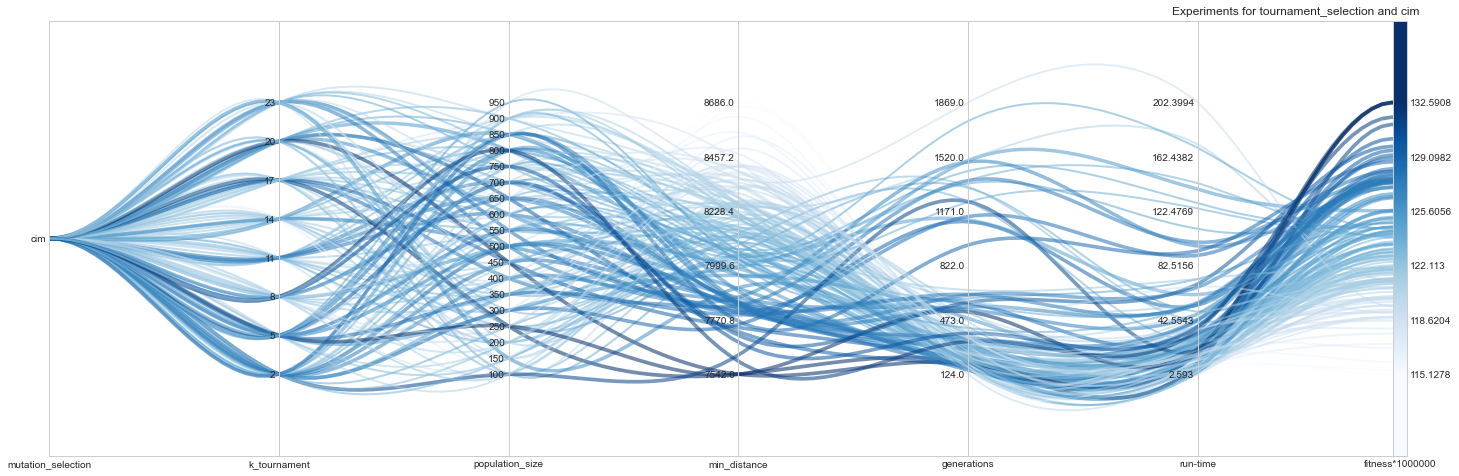

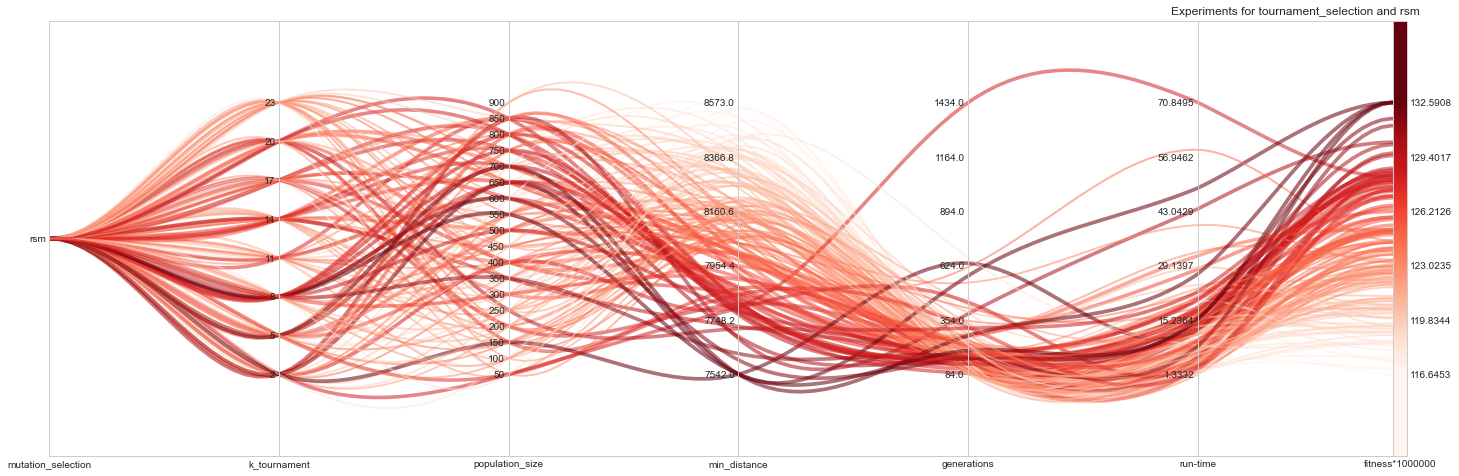

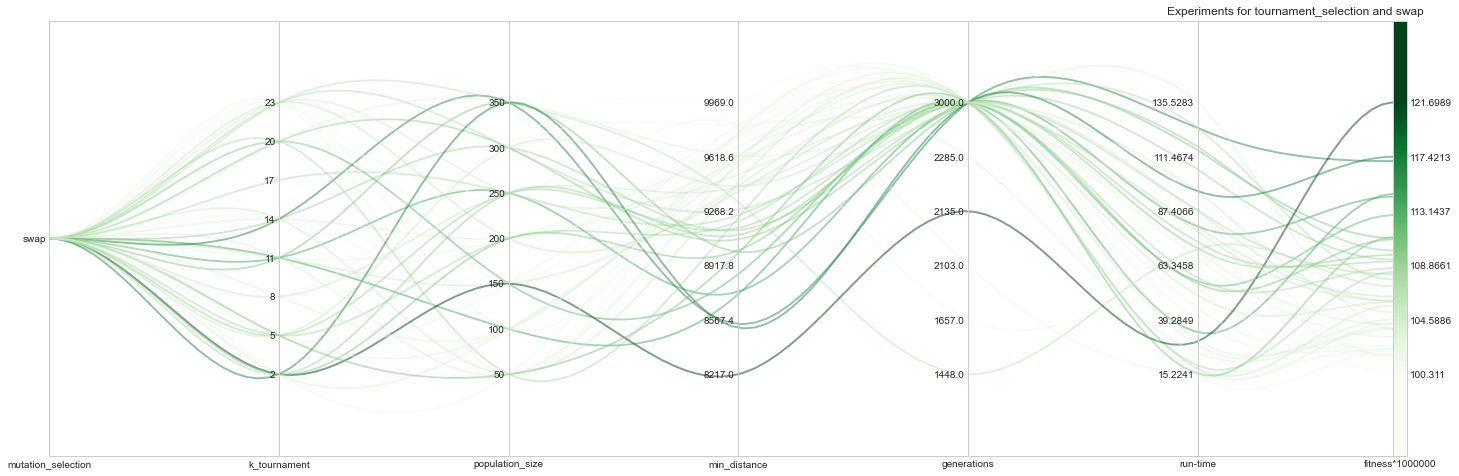

In [8]:
df = load_df()
print('Total number of experiments: {}'.format(df.values.shape[0]))
_ = parallel_plot(df.loc[(df['parent_selection'] == 'tournament_selection') & (df['mutation_selection'] == 'cim') 
                         & (df['min_distance'] <= 8700) ],
              ['mutation_selection',  'k_tournament', 'population_size', 'min_distance', 'generations', 'run-time'],
              rank_attr = 'fitness*1000000', title = 'Experiments for tournament_selection and cim', 
              curved = True, cmap = 'Blues', curvedextend = 0.3,
              output = './plots/tournament_selection_coord_cim_plot.png')

_ = parallel_plot(df.loc[(df['parent_selection'] == 'tournament_selection') & (df['mutation_selection'] == 'rsm') 
                         & (df['min_distance'] <= 8700) ],
              ['mutation_selection',  'k_tournament', 'population_size', 'min_distance', 'generations', 'run-time'],
              rank_attr = 'fitness*1000000', title = 'Experiments for tournament_selection and rsm', 
              curved = True, cmap = 'Reds',  curvedextend = 0.3, 
              output = './plots/tournament_selection_coord_rsm_plot.png')
_ = parallel_plot(df.loc[(df['parent_selection'] == 'tournament_selection') & (df['mutation_selection'] == 'swap') 
                         & (df['min_distance'] <= 10000) ],
              ['mutation_selection',  'k_tournament', 'population_size', 'min_distance', 'generations', 'run-time'],
              rank_attr = 'fitness*1000000', title = 'Experiments for tournament_selection and swap', 
              curved = True, cmap = 'Greens',  curvedextend = 0.3, 
              output = './plots/tournament_selection_coord_swap_plot.png')

Total number of experiments: 385


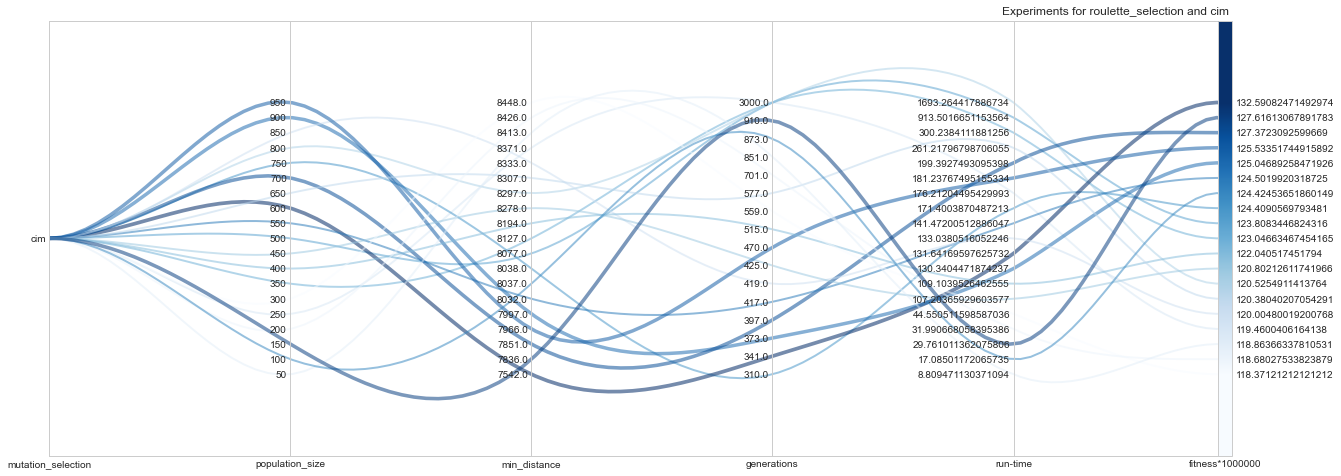

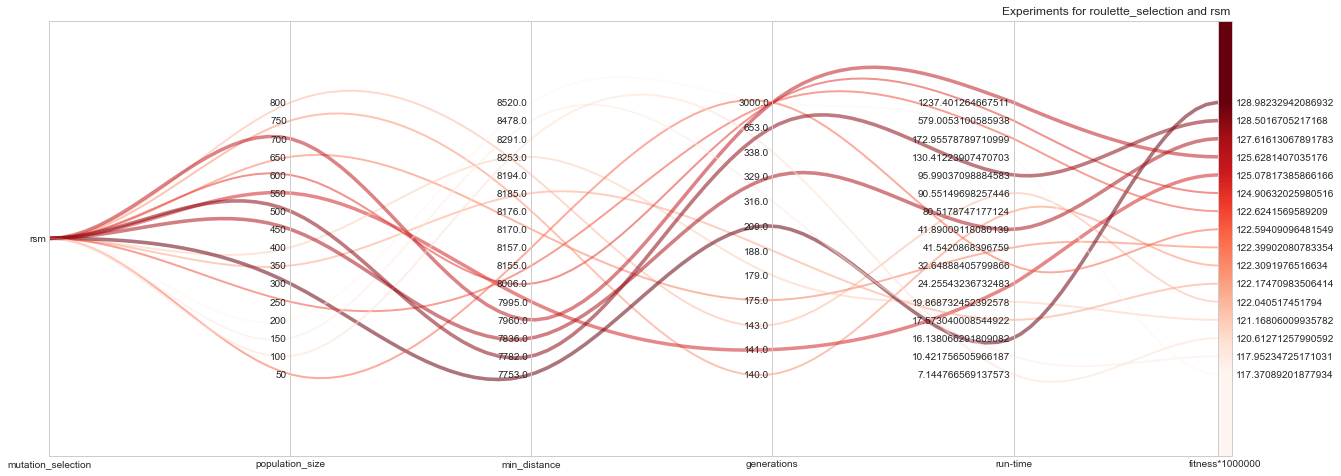

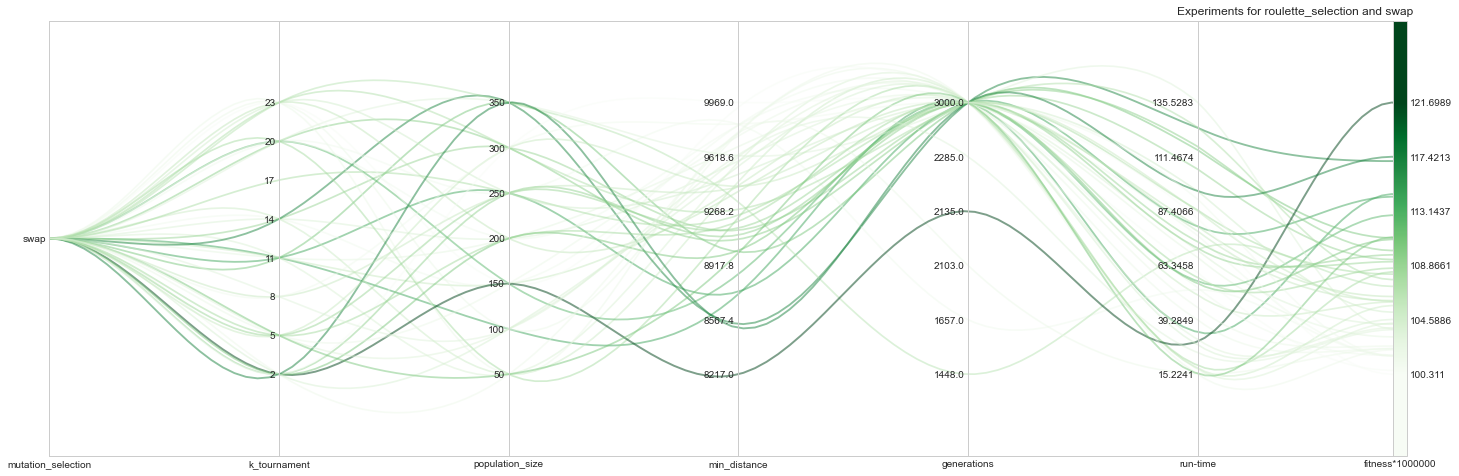

In [9]:
df = load_df()
print('Total number of experiments: {}'.format(df.values.shape[0]))
_ = parallel_plot(df.loc[(df['parent_selection'] == 'parent_selection2') & (df['mutation_selection'] == 'cim') 
                         & (df['min_distance'] <= 8700) ],
              ['mutation_selection', 'population_size', 'min_distance', 'generations', 'run-time'],
              rank_attr = 'fitness*1000000', title = 'Experiments for roulette_selection and cim', 
              curved = True, cmap = 'Blues', curvedextend = 0.3,
              output = './plots/roulette_selection_coord_cim_plot.png')

_ = parallel_plot(df.loc[(df['parent_selection'] == 'parent_selection2') & (df['mutation_selection'] == 'rsm') 
                         & (df['min_distance'] <= 8700) ],
              ['mutation_selection', 'population_size', 'min_distance', 'generations', 'run-time'],
              rank_attr = 'fitness*1000000', title = 'Experiments for roulette_selection and rsm', 
              curved = True, cmap = 'Reds',  curvedextend = 0.3, 
              output = './plots/roulette_selection_coord_rsm_plot.png')

_ = parallel_plot(df.loc[(df['parent_selection'] == 'tournament_selection') & (df['mutation_selection'] == 'swap') 
                         & (df['min_distance'] <= 10000) ],
              ['mutation_selection',  'k_tournament', 'population_size', 'min_distance', 'generations', 'run-time'],
              rank_attr = 'fitness*1000000', title = 'Experiments for roulette_selection and swap', 
              curved = True, cmap = 'Greens',  curvedextend = 0.3, 
              output = './plots/roulette_selection_coord_swap_plot.png')